In [1]:
from ema_workbench import Scenario, Policy, MultiprocessingEvaluator, ema_logging, load_results, save_results
from ema_workbench.analysis import prim
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ema_workbench.analysis import parcoords
import seaborn as sns
import random
from sklearn import preprocessing

In [2]:
ACTORNAME = "Overijssel"
dike_model, planning_steps = get_model_for_problem_formulation(ACTORNAME)
outcomekeys = [outcome.name for outcome in dike_model.outcomes]

# Scenario selection

In [3]:
ACTOR = "genscen_Overijssel_50000_12-06-2021-02-18-42.tar.gz"
experiments, outcomes = load_results("data/generated/" + ACTOR)
outcomes_df = pd.DataFrame(outcomes)

In [4]:
outcomes_df.columns.values.tolist()

['Gorssel and Deventer Expected Annual Damage',
 'Gorssel and Deventer Expected Number of Deaths',
 'Gorssel and Deventer Total Costs']

In [5]:
DAMAGE = outcomes_df.columns[0]
DEATHS = outcomes_df.columns[1]
COSTS = outcomes_df.columns[2]

We are interested in the correlation between Deaths and Damage

In [6]:
outcomes_df[DAMAGE].corr(outcomes_df[DEATHS])

0.9757264909805828

So the correlation is INSANE

In [7]:
results = pd.concat([experiments, outcomes_df], axis=1)

In [10]:
uncertainties =list(dike_model.uncertainties._data.keys())

In [11]:
print(outcomes_df.idxmax())
print(outcomes_df.idxmin())

Gorssel and Deventer Expected Annual Damage         959
Gorssel and Deventer Expected Number of Deaths    35550
Gorssel and Deventer Total Costs                      0
dtype: int64
Gorssel and Deventer Expected Annual Damage       780
Gorssel and Deventer Expected Number of Deaths    780
Gorssel and Deventer Total Costs                    0
dtype: int64


In [16]:
middle_damage_df = results.loc[(results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=23)) & (results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=27))]
middle_deaths_df = results.loc[(results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=23)) & (results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=27))]
twentyfive = random.choice(list(set(middle_damage_df["scenario"].tolist()) & set(middle_deaths_df["scenario"].tolist())))

In [17]:
middle_damage_df = results.loc[(results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=48)) & (results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=52))]
middle_deaths_df = results.loc[(results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=48)) & (results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=52))]
fifty = random.choice(list(set(middle_damage_df["scenario"].tolist()) & set(middle_deaths_df["scenario"].tolist())))

In [18]:
middle_damage_df = results.loc[(results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=73)) & (results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=77))]
middle_deaths_df = results.loc[(results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=73)) & (results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=77))]
seventyfive = random.choice(list(set(middle_damage_df["scenario"].tolist()) & set(middle_deaths_df["scenario"].tolist())))

In [19]:
outcomes_df.loc[outcomes_df[DAMAGE] == outcomes_df.max()[0]]

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs
959,1.651202e+09,1.058792,0


In [20]:
min_max_scaler = preprocessing.MinMaxScaler()
damage_scaled = min_max_scaler.fit_transform(pd.DataFrame(outcomes[DAMAGE]).values)
deaths_scaled = min_max_scaler.fit_transform(pd.DataFrame(outcomes[DEATHS]).values)
scaled = (damage_scaled + deaths_scaled)/2

In [21]:
outcomes_df["Scaled"] = scaled
SCALED = 'Scaled'

In [22]:
outcomes_df.sort_values(by="Scaled", ascending=False).head(1).index[0]

959

Observation: Deventer more people die absolute worst
explanation: more densely populated

In [23]:
idx = [outcomes_df.idxmin()[DAMAGE], twentyfive, fifty, seventyfive, outcomes_df.idxmax()[DEATHS], outcomes_df.idxmax()[DAMAGE]]

In [24]:
idx

[780, 26410, 10135, 425, 35550, 959]

In [25]:
cases = {0: "best", 1: "low", 2: "middle", 3: "high", 4: "worst deaths", 5: "absolute worst"}

In [26]:
selected = results.iloc[idx]

In [27]:
selected = selected.loc[:,  uncertainties]

In [28]:
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [29]:
outcomes_df.describe()

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs,Scaled
count,5.000000e+04,50000.000000,50000.0,50000.000000
mean,2.238156e+08,0.185281,0.0,0.152460
std,2.662215e+08,0.236627,0.0,0.187645
min,0.000000e+00,0.000000,0.0,0.000000
25%,6.118422e+07,0.036801,0.0,0.036152
50%,1.228096e+08,0.073162,0.0,0.074426
75%,2.556901e+08,0.219267,0.0,0.178319
max,1.651202e+09,1.093926,0.0,0.983941


# Optimisation

In [30]:
hypervolumemin = [0,0,0]
hypervolumemax = outcomes_df[outcomekeys].max(axis=0).values.tolist()

In [31]:
hypervolumemax[2] = 1.15e9

In [ ]:
ema_logging.log_to_stderr(ema_logging.INFO)

nfe = 3000 + 1000

def optimize(scenario, nfe, model, converge_metrics, epsilons):


    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario, convergence_freq=200)
    return results, convergence

scenario = scenarios[5]
results = []
convergence_metrics = [HyperVolume(minimum=hypervolumemin, maximum=hypervolumemax),
                       EpsilonProgress()]
epsilons = [1e5, 0.01, 1e5]



results.append(optimize(scenario, nfe, dike_model, convergence_metrics, epsilons))



# results = []
# for scenario in scenarios:
#     convergence_metrics = [HyperVolume(minimum=hypervolumemin, maximum=hypervolumemax),
#                            EpsilonProgress()]
#     epsilons = [1e3, 0.001, 1e5]
    
    
    
#     results.append(optimize(scenario, nfe, dike_model, convergence_metrics, epsilons))


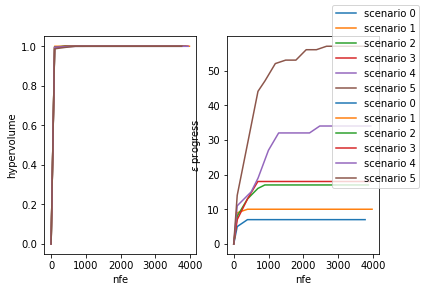

In [37]:
fig, (ax1, ax2) = plt.subplots(ncols=2,sharex=True)
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

# Saving

In [38]:
for i, (result, convergence) in enumerate(results):
    result.to_csv("data/optimisation/" + ACTORNAME + "/results_" + cases[i] +".csv", index=False)
    convergence.to_csv("data/optimisation/" + ACTORNAME + "/convergence_" + cases[i] +".csv", index=False)

In [39]:
selected.to_csv("data/optimisation/" + ACTORNAME + "/selected.csv", index=False)

# Re-evaluate under deep uncertainty

In [40]:
n_scenarios = 1000

In [41]:
levers = [lever.name for lever in dike_model.levers]

In [42]:
policies = []
for i, (result, _) in enumerate(results):
    result = result.loc[:, levers]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {cases[i]} option {j}', **row.to_dict())
        policies.append(policy)

In [43]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    reevaluation_results = evaluator.perform_experiments(n_scenarios, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 14 policies * 1 model(s) = 14000 experiments
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 4200 cases completed
[MainProcess/INFO] 5600 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9800 cases completed
[MainProcess/INFO] 11200 cases completed
[MainProcess/INFO] 12600 cases completed
[MainProcess/INFO] 14000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


# Saving

In [45]:
save_results(reevaluation_results, "data/optimisation/du_scen_" + str(n_scenarios) + "_" + ACTORNAME + ".tar.gz")

[MainProcess/INFO] results saved successfully to /Users/emilyryan/Dropbox/EPA/EPA1361/FabiosDecisions/epa1361/final assignment/data/optimisation/du_scen_1000_Gorssel.tar.gz
